
Dataset Overview
Shape: (4600, 18)

Feature Names:  ['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'street', 'city', 'statezip', 'country']

Data Types:
 date              object
price            float64
bedrooms         float64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
street            object
city              object
statezip          object
country           object
dtype: object

Missing Values:
 date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
sqft_above       0
sqft_basement    0
yr_built

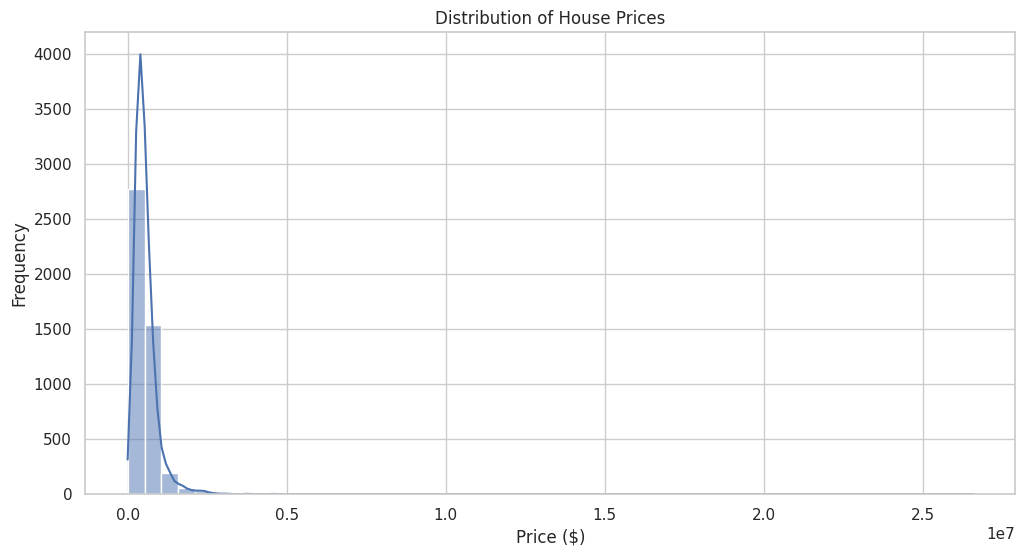

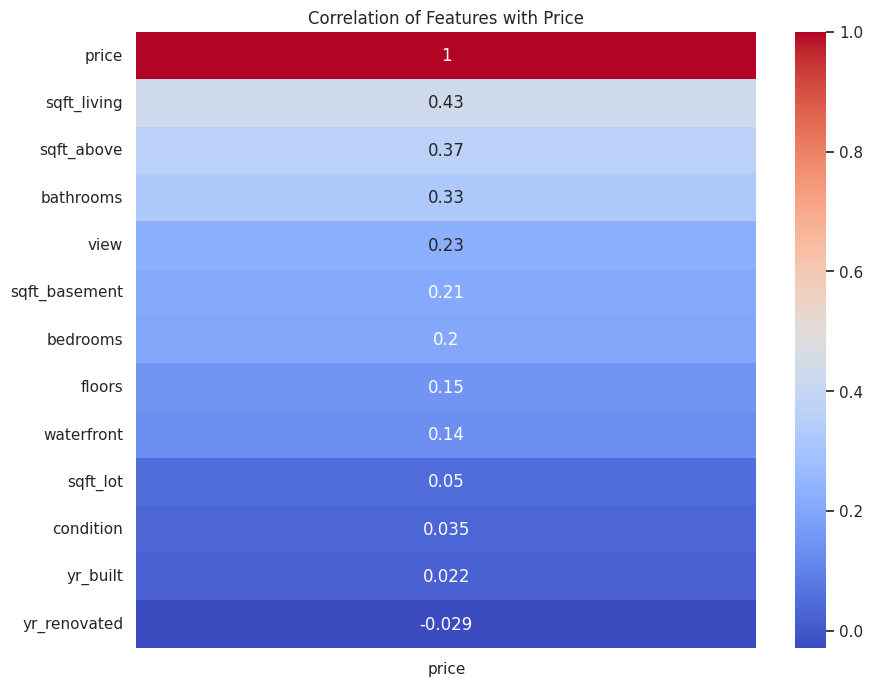

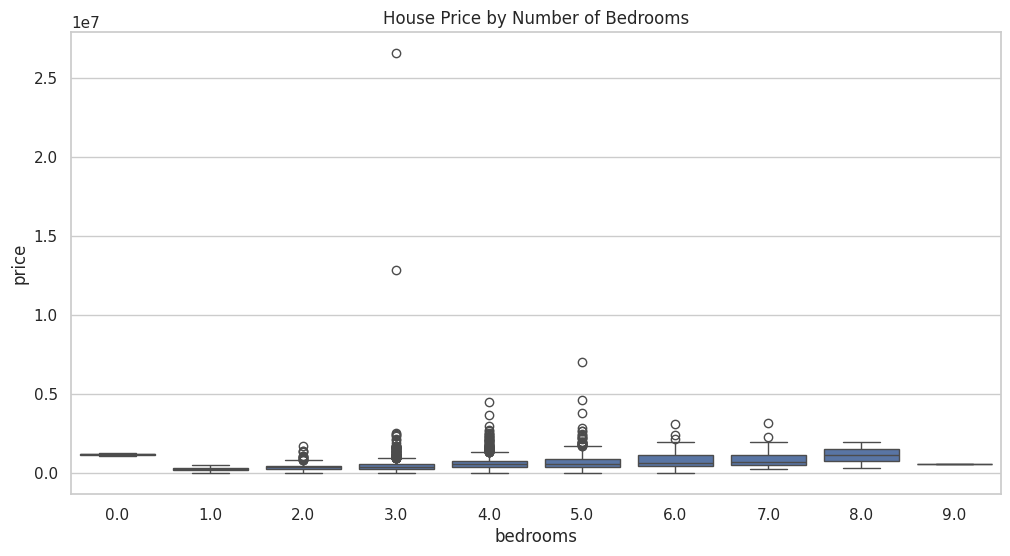

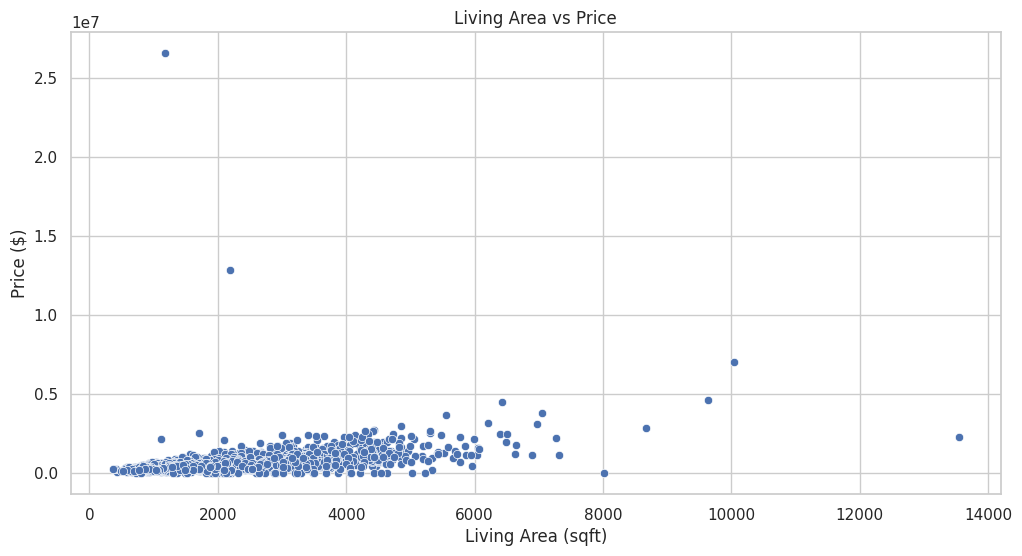

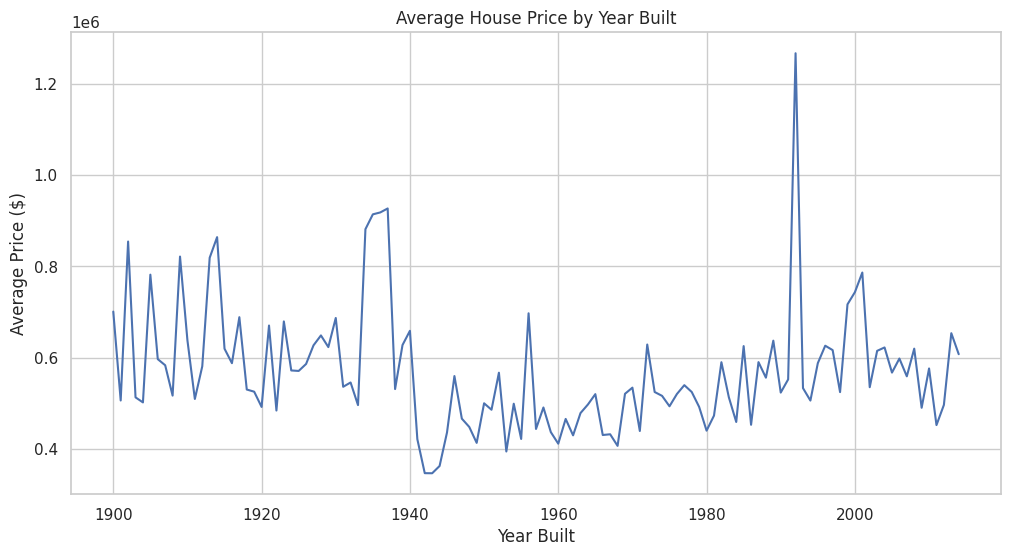

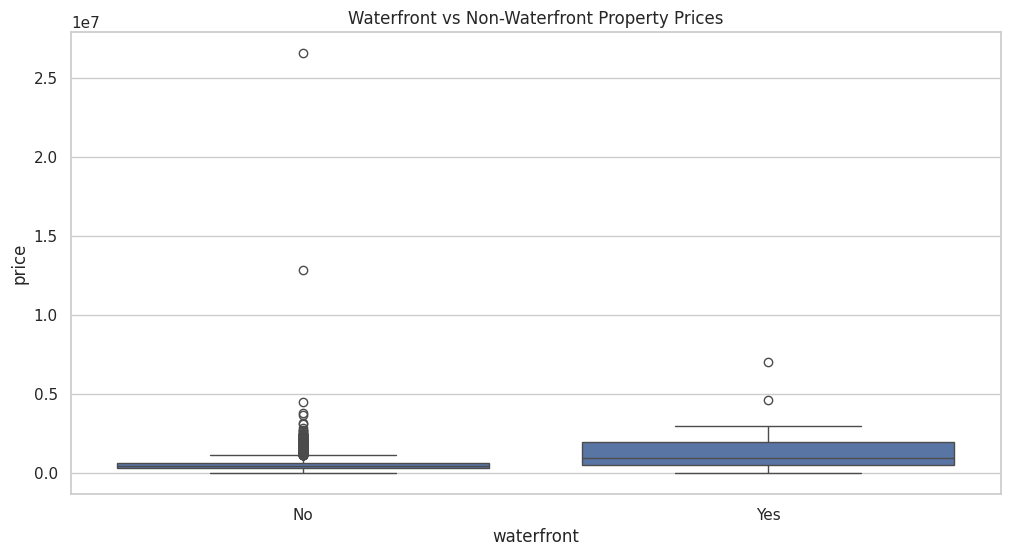


Top 10 Features Correlated with Price:
price            1.000000
sqft_living      0.430410
sqft_above       0.367570
bathrooms        0.327110
view             0.228504
sqft_basement    0.210427
bedrooms         0.200336
floors           0.151461
waterfront       0.135648
sqft_lot         0.050451
Name: price, dtype: float64
Linear Regression → R²: -0.111, MSE: 895,731.93, MAE: 199,120.56
Ridge → R²: 0.419, MSE: 648,097.15, MAE: 94,727.23


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 165766000535.76138, tolerance: 46468024580.791954
  model = cd_fast.sparse_enet_coordinate_descent(


Lasso → R²: -0.238, MSE: 945,664.56, MAE: 173,605.92
Decision Tree → R²: 0.196, MSE: 762,005.11, MAE: 52,162.83
Random Forest → R²: 0.204, MSE: 758,125.99, MAE: 37,513.58
Gradient Boosting → R²: 0.238, MSE: 741,961.91, MAE: 43,453.22
XGBoost → R²: 0.212, MSE: 754,324.74, MAE: 46,011.53


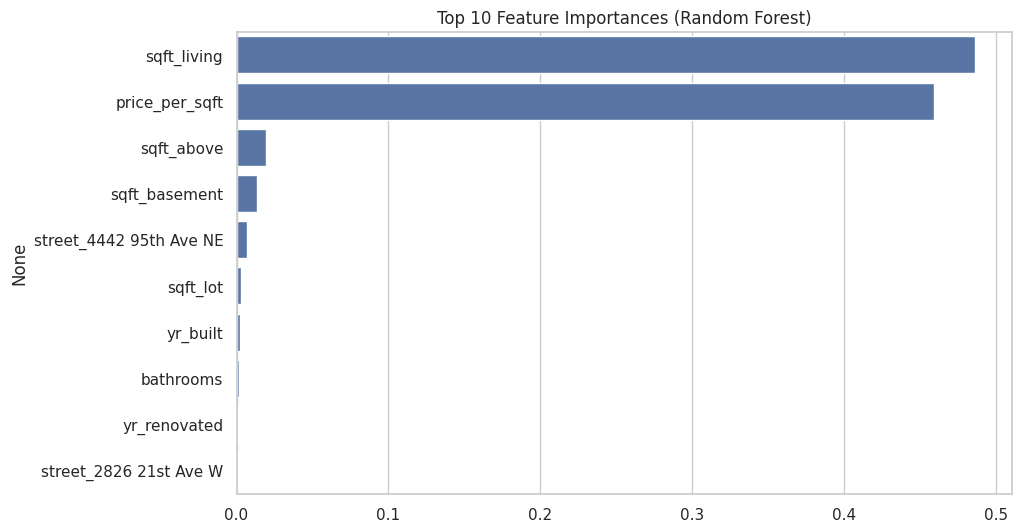


Best Decision Tree Params: {'model__max_depth': 10, 'model__min_samples_leaf': 2, 'model__min_samples_split': 2}
Best CV R²: 0.9453319114291869


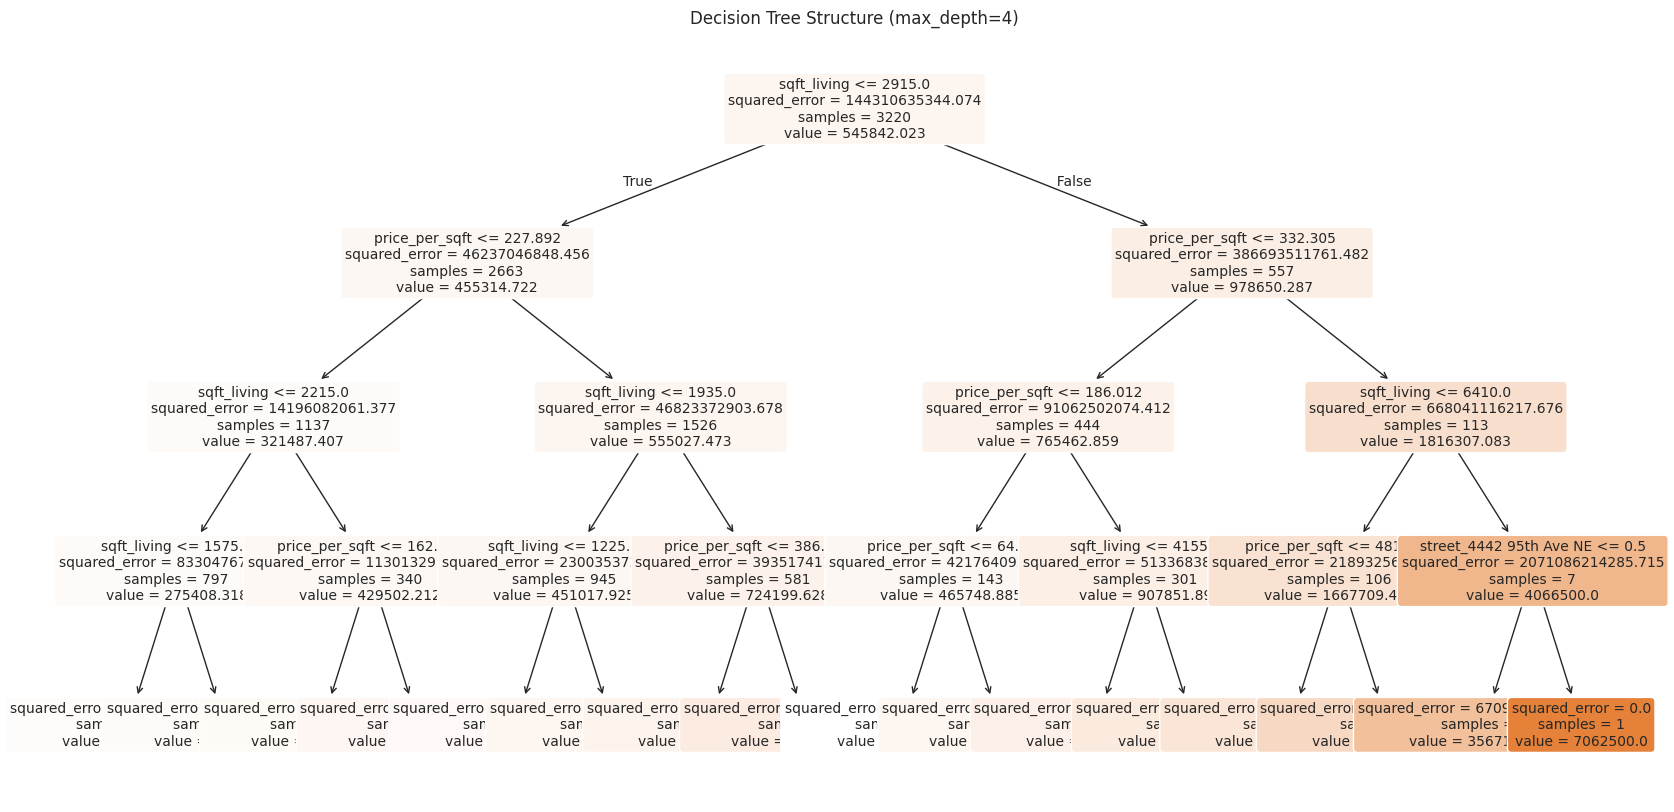

In [ ]:

# 1. Problem Statement
# ------------------------------------------
# What are the key factors that affect house prices in King County, Washington, and can we use
# them to predict a property's sale price?

# 2. Import Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error


sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

df = pd.read_csv("data.csv")

print("\nDataset Overview")
print("Shape:", df.shape)
print("\nFeature Names: ", df.columns.tolist())
print("\nData Types:\n", df.dtypes)
print("\nMissing Values:\n", df.isnull().sum())
print("\nSummary Statistics:\n", df.describe())


# 4. EDA
sns.histplot(df['price'], bins=50, kde=True)
plt.title('Distribution of House Prices')
plt.xlabel('Price ($)')
plt.ylabel('Frequency')
plt.show()

correlation_matrix = df.corr(numeric_only=True)
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix[['price']].sort_values(by='price', ascending=False), annot=True, cmap='coolwarm')
plt.title("Correlation of Features with Price")
plt.show()

sns.boxplot(x='bedrooms', y='price', data=df)
plt.title('House Price by Number of Bedrooms')
plt.show()

sns.scatterplot(x='sqft_living', y='price', data=df)
plt.title('Living Area vs Price')
plt.xlabel('Living Area (sqft)')
plt.ylabel('Price ($)')
plt.show()

yearly_avg = df.groupby('yr_built')['price'].mean().reset_index()
sns.lineplot(x='yr_built', y='price', data=yearly_avg)
plt.title('Average House Price by Year Built')
plt.xlabel('Year Built')
plt.ylabel('Average Price ($)')
plt.show()

sns.boxplot(x='waterfront', y='price', data=df)
plt.title('Waterfront vs Non-Waterfront Property Prices')
plt.xticks([0,1], ['No', 'Yes'])
plt.show()

print("\nTop 10 Features Correlated with Price:")
print(correlation_matrix['price'].sort_values(ascending=False).head(10))

# 5. Feature Engineering
df['price_per_sqft'] = df['price'] / df['sqft_living']
df['log_price'] = np.log1p(df['price'])

# Target and features
y = df['price']
X = df.drop(columns=['price', 'log_price'])

# Identify categorical/numerical columns
cat_features = X.select_dtypes(include=['object']).columns
num_features = X.select_dtypes(exclude=['object']).columns

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ("num", RobustScaler(), num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features)
    ]
)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor

# 6. Modeling
models = {
    "Linear Regression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.1),
    "Decision Tree": DecisionTreeRegressor(max_depth=10, random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=3, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=3, random_state=42)
}

results = []
for name, model in models.items():
    pipe = Pipeline(steps=[("preprocessor", preprocessor), ("model", model)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    results.append((name, r2, mse, mae))
    print(f"{name} → R²: {r2:.3f}, MSE: {mse:,.2f}, MAE: {mae:,.2f}")

# 7. Feature Importance (Tree Models)
rf_model = Pipeline(steps=[("preprocessor", preprocessor), ("model", RandomForestRegressor(n_estimators=100, random_state=42))])
rf_model.fit(X_train, y_train)

# Extract feature names after preprocessing
encoded_feature_names = list(num_features) + list(rf_model.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(cat_features))
importances = rf_model.named_steps['model'].feature_importances_
feat_imp = pd.Series(importances, index=encoded_feature_names).sort_values(ascending=False)[:10]

plt.figure(figsize=(10,6))
sns.barplot(x=feat_imp.values, y=feat_imp.index)
plt.title("Top 10 Feature Importances (Random Forest)")
plt.show()

# 8. Hyperparameter Tuning Example (Decision Tree)
param_grid = {
    'model__max_depth': [5, 10, 20],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}

dt_pipe = Pipeline(steps=[("preprocessor", preprocessor), ("model", DecisionTreeRegressor(random_state=42))])
grid_search = GridSearchCV(dt_pipe, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("\nBest Decision Tree Params:", grid_search.best_params_)
print("Best CV R²:", grid_search.best_score_)

# 9. Decision Tree Visualization
from sklearn import tree

X_encoded = pd.get_dummies(X, drop_first=True)
X_train_enc, X_test_enc, y_train_enc, y_test_enc = train_test_split(X_encoded, y, test_size=0.3, random_state=42)

dt_simple = DecisionTreeRegressor(max_depth=4, random_state=42)
dt_simple.fit(X_train_enc, y_train_enc)

# Plot the tree
plt.figure(figsize=(20, 10))
plot_tree(dt_simple,
          feature_names=X_encoded.columns,
          filled=True,
          rounded=True,
          fontsize=10)
plt.title("Decision Tree Structure (max_depth=4)")
plt.show()
